In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from Higgs.tools.ImplementationUtils import (
    implementPairDecayLimit,
    fromHB5Table1,
    readHEPDataCsv,
)
from Higgs import bounds as HB
from Higgs import predictions as HP
from Higgs import Predictions

import os, sys

sys.path.insert(0, os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd()))))
import MassResolutions as resolution


# CMS 13TeV LHC

## `hSM > a a > 4 tau/mumutautau` [1907.07235](https://arxiv.org/abs/1907.07235)


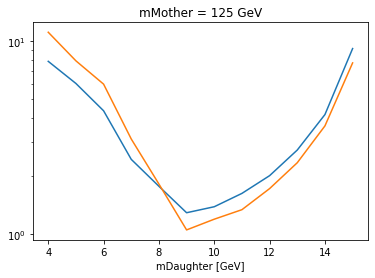

Looks good. Saving this to comb_LHC13_CMS_36.json


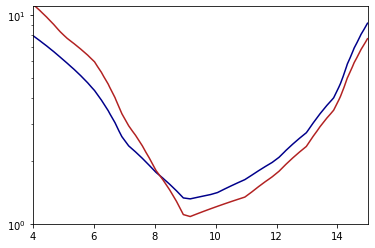

In [2]:
dfs = readHEPDataCsv("https://www.hepdata.net/download/table/ins1744267/Table/1/csv")

df = dfs[-1].rename(
    columns={
        "m(a) [GeV]": "mDaughter1",
        "95% CL upper limit on (sigma(pp->h)/sigma(pp->hSM)) * B(h -> aa -> tautau tautau)": "obs",
    }
)
assert np.allclose(df.mDaughter1, dfs[2]["m(a) [GeV]"])
df["exp"] = dfs[2][
    "95% CL upper limit on (sigma(pp->h)/sigma(pp->hSM)) * B(h -> aa -> tautau tautau)"
]
df["mMother"] = 125
prods = ["H", "vbfH", "Htt", "HZ", "HW"]

refCxn = np.sum([HP.SMHiggs(125).cxn("LHC13", x) for x in prods])
df.obs *= refCxn
df.exp *= refCxn
limitFile = implementPairDecayLimit(
    "1907.07235",
    {
        "production": prods,
        "firstDecay": ["tautau"],
        "secondDecay": ["tautau"],
    },
    "https://www.hepdata.net/record/ins1744267",
    df,
    massResolution={
        "firstDaughter": resolution.tautau["default"],
        "secondDaughter": resolution.tautau["default"],
        "mother": {
            "absolute": 20,  # wild guess, not sure this is even reconstructed at all
            "relative": 0,
        },
    },
    constraints={
        "mother": [
            {
                "modelLike": "SMHiggs",
                "process": {"channels": [[p, "none"] for p in prods]},
            }
        ],
        "firstDaughter": [{"mumuTautauRatio": "odd"}],
        "secondDaughter": [{"mumuTautauRatio": "odd"}],
    },
)
lim = HB.Limit(limitFile)
pred = Predictions()
hh = pred.addParticle(HP.NeutralScalar("hh"))
hh.setDecayWidth("h1", "h1", 1.0)
h1 = pred.addParticle(HP.NeutralScalar("h1"))
h1.setDecayWidth("tautau", 1.0)
hh.setMass(125)
hm = np.linspace(4, 15)
r = np.linspace(0.01, 0.6)

mmu = 105.6583715e-3
mtau = 1.77682


def testAgainstLimit(mass, rate):
    from math import sqrt

    h1.setMass(mass)
    h1.setDecayWidth(
        "mumu",
        mmu ** 2
        / mtau ** 2
        / sqrt(1 - (2 * mtau / h1.mass()) ** 2)
        * h1.br("tautau")
        * h1.totalWidth(),
    )
    HP.effectiveCouplingInput(hh, HP.scaledSMlikeEffCouplings(sqrt(rate)))
    hh.setDecayWidth("h1", "h1", 100.0)
    app = lim.apply(pred)
    if len(app) == 0:
        print("Limit not applied for ", mass, rate)
        return (0, 0)
    return (app[0].expRatio(), app[0].obsRatio())


test = np.frompyfunc(testAgainstLimit, 2, 2)
XX, YY = np.meshgrid(hm, r)
expR, obsR = test(XX, YY)
fig, ax = plt.subplots()
ax.set_yscale("log")
ax.set_ylim(1, 11)
expCc = ax.contour(hm, r * refCxn, expR, levels=[1], colors=["darkblue"])
obsCc = ax.contour(hm, r * refCxn, obsR, levels=[1], colors=["firebrick"])
ax.contourf(hm, r, obsR)
expCc.collections[0].set_label("expRatio = 1")
obsCc.collections[0].set_label("obsRatio = 1")
plt.show()


# CMS 8TeV LHC

## `hSM > h h > 4tau` [1701.02032](https://arxiv.org/abs/1701.02032)


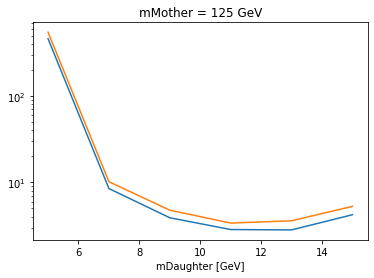

Looks good. Saving this to comb_LHC8_CMS_20.json


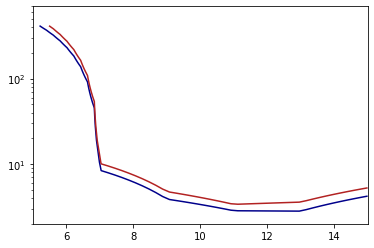

In [3]:
df = fromHB5Table1("170102032_CMS_HSM-aa-tautau_19.7fb-1", "CMS").rename(
    columns={"m": "mDaughter1"}
)
df["mMother"] = 125
prodModes = ["H", "vbfH", "HW", "HZ"]
ref = HP.SMHiggs(125)
refCxn = np.sum([ref.cxn("LHC8", p) for p in prodModes])
df.obs *= refCxn
df.exp *= refCxn
limitFile = implementPairDecayLimit(
    "1701.02032",
    {
        "production": prodModes,
        "firstDecay": ["tautau"],
        "secondDecay": ["tautau"],
    },
    "Fig. 4",
    df,
    idSuffix=1, # other ids have different channels
    massResolution={
        "firstDaughter": resolution.tautau["default"],
        "secondDaughter": resolution.tautau["default"],
        "mother": {
            "absolute": 20,
            "relative": 0,
        },
    },
    constraints={
        "mother": [
            {
                "modelLike": "SMHiggs",
                "process": {"channels": [[p, "none"] for p in prodModes]},
            }
        ]
    },
)
lim = HB.Limit(limitFile)

pred = Predictions()
hh = pred.addParticle(HP.NeutralScalar("hh"))
h1 = pred.addParticle(HP.NeutralScalar("h1"))
h1.setDecayWidth("tautau", 1.0)
hh.setMass(125)
hm = np.linspace(5, 15)
r = np.linspace(0.1, 20)


def testAgainstLimit(mass, rate):
    from math import sqrt

    h1.setMass(mass)
    HP.effectiveCouplingInput(hh, HP.scaledSMlikeEffCouplings(sqrt(rate)))
    hh.setDecayWidth("h1", "h1", 100)
    app = lim.apply(pred)
    if len(app) == 0:
        print("Limit not applied for ", mass, rate)
        return (0, 0)
    return (app[0].expRatio(), app[0].obsRatio())


test = np.frompyfunc(testAgainstLimit, 2, 2)
XX, YY = np.meshgrid(hm, r)
expR, obsR = test(XX, YY)
fig, ax = plt.subplots()
ax.set_yscale("log")
expCc = ax.contour(hm, r * refCxn, expR, levels=[1], colors=["darkblue"])
obsCc = ax.contour(hm, r * refCxn, obsR, levels=[1], colors=["firebrick"])
expCc.collections[0].set_label("expRatio = 1")
obsCc.collections[0].set_label("obsRatio = 1")
ax.set_ylim(2, 700)
plt.show()


## `hSM > h h > 4 tau` [1510.06534](https://arxiv.org/abs/1510.06534)

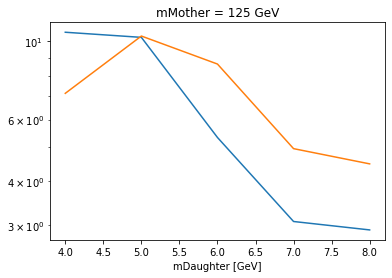

Looks good. Saving this to ggH_LHC8_CMS_20.json


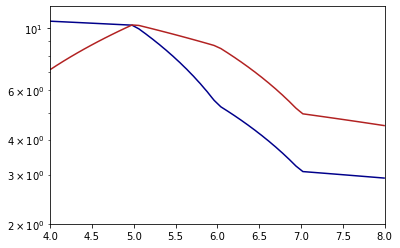

In [4]:
df = fromHB5Table1("1506534_CMS_gg-H-hh-tautautautau_19.7fb-1", "CMS").rename(
    columns={"m": "mDaughter1"}
)
df["mMother"] = 125
limitFile = implementPairDecayLimit(
    "1510.06534",
    {
        "production": ["ggH"],
        "firstDecay": ["tautau"],
        "secondDecay": ["tautau"],
    },
    "Fig. 8",
    df,
    massResolution={
        "firstDaughter": resolution.tautau["default"],  # bin width
        "secondDaughter": resolution.tautau["default"],
        "mother": {
            "absolute": 20,
            "relative": 0,
        },
    },
)
lim = HB.Limit(limitFile)

pred = Predictions()
hh = pred.addParticle(HP.NeutralScalar("hh"))
h1 = pred.addParticle(HP.NeutralScalar("h1"))
hh.setDecayWidth("h1", "h1", 1.0)
h1.setDecayWidth("tautau", 1.0)
hh.setMass(125)
hm = np.linspace(4, 8)
r = np.linspace(2, 12)


def testAgainstLimit(mass, rate):
    h1.setMass(mass)
    hh.setCxn("LHC8", "ggH", rate)
    app = lim.apply(pred)
    if len(app) == 0:
        print("Limit not applied for ", mass, rate)
        return (0, 0)
    return (app[0].expRatio(), app[0].obsRatio())


test = np.frompyfunc(testAgainstLimit, 2, 2)
XX, YY = np.meshgrid(hm, r)
expR, obsR = test(XX, YY)
fig, ax = plt.subplots()
expCc = ax.contour(hm, r, expR, levels=[1], colors=["darkblue"])
obsCc = ax.contour(hm, r, obsR, levels=[1], colors=["firebrick"])
expCc.collections[0].set_label("expRatio = 1")
obsCc.collections[0].set_label("obsRatio = 1")
ax.set_yscale("log")
plt.show()